# Health Analytics based on Apple Health Data

The project takes Raw Data from iPhone and converts the datapoints like Step Count, Sleep, Flights Climbed to build a Health Analytics and Prediction System that can be useful to understand patterns. We have also collected user **User Information** for all our 25 User Base whose data we have have analysed in this Project.

This project will be extremely helpful to understand User Health Patterns and help users self-reflect their Health Metrics with respect to their friends and community

**Libraries used:**

1. Pandas
2. Numpy
3. Matplotlib
4. Seaborn
5. Sklearn
6. Pyplot
7. CalMap

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import os.path
from pathlib import Path
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import calmap

Read the data from CSV for all the 25 Users that we collected XML and converted to CSV

In [2]:
def read_files(filename, number_folders, delimiter = ';'):
    data = []
    for i in range(1,number_folders+1):
        file = "users/"+str(i)+"/"+str(filename)
        my_file = Path(file)
        if my_file.is_file():
            df = pd.read_csv(file, delimiter = ';')
            data.append(df)
        else:
#             data.append(["Not Found"])
            print(i, filename, "Not found")
    return data

data = read_files('HKQuantityTypeIdentifierStepCount.csv', 25)

## Data Pre-Processing and Feature Engineering

In this step we preporcess the data and perform feature engineering as follows:

1. Drop Unuseful Columns
2. Remove -400 from all time fields like creationDate, startDate,endDate
3. Split date time into separate features: Date and Time
4. Drop Unuseful Time fields
5. Create new features

In [3]:
def preprocess(data, drop_columns):
    """
    Input:
        list of df (dataframe): input list of all dataframes
    Output:
        list of df (dataframe): input list of all dataframes
    """
    number_folders = len(data)
    for i in range(1,number_folders+1):
        # drop unuseful columns
        data[i-1].drop(drop_columns,axis = 1, inplace=True)
        # remove the string -400 from date field
        data[i-1]['creationDate'] = data[i-1]['creationDate'].astype(str).str[:-6]
        data[i-1]['startDate'] = data[i-1]['startDate'].astype(str).str[:-6]
        data[i-1]['endDate'] = data[i-1]['endDate'].astype(str).str[:-6]
    return data

column_names = ['type','sourceName','sourceVersion','device','unit']
data_clean = preprocess(data, column_names)

The below method is used to split date time features separately for the purpose of extracting day, time, hour of the day

In [4]:
def time_transformation(df):
    """
    Input:
        df (dataframe): input dataframe
    Output:
        df (dataframe): return a dataframe with formatted datetime columns
    """
    df['CREATION_DATE'] = df['creationDate'].apply(lambda x : x.split(' ')[0])
    df['CREATION_DATE'] = pd.to_datetime(df['CREATION_DATE'],format='%Y-%m-%d')
    df['CREATION_TIME'] = df['creationDate'].apply(lambda x : x.split(' ')[1])
    df['CREATION_TIME'] = pd.to_datetime(df['CREATION_TIME'],format='%H:%M:%S').apply(lambda x:x.time())
    
    df['START_DATE'] = df['startDate'].apply(lambda x : x.split(' ')[0])
    df['START_DATE'] = pd.to_datetime(df['START_DATE'],format='%Y-%m-%d')
    df['START_TIME'] = df['startDate'].apply(lambda x : x.split(' ')[1])
    df['START_TIME'] = pd.to_datetime(df['START_TIME'],format='%H:%M:%S').apply(lambda x:x.time())
    
    df['END_DATE'] = df['endDate'].apply(lambda x : x.split(' ')[0])
    df['END_DATE'] = pd.to_datetime(df['END_DATE'],format='%Y-%m-%d')
    df['END_TIME'] = df['endDate'].apply(lambda x : x.split(' ')[1])
    df['END_TIME'] = pd.to_datetime(df['END_TIME'],format='%H:%M:%S').apply(lambda x:x.time())
    return df

In [5]:
def perfom_time_transform(data):
    number_folders = len(data)
    for i in range(1,number_folders+1):
        data[i-1] = time_transformation(data[i-1])        
        data[i-1].drop((['creationDate','startDate','endDate','CREATION_DATE','CREATION_TIME',
                         'END_TIME','START_DATE','START_TIME']), axis=1, inplace=True)
    return data

data_transform = perfom_time_transform(data)

In [6]:
data_transform[1].head(5)

value   END_DATE
0    119 2014-11-22
1    104 2014-11-22
2     78 2014-11-22
3     78 2014-11-22
4     10 2014-11-22

Create new features for date field:

1. date by month 
2. day_of_week
3. year and 
4. day

In [7]:
def create_date_features(data):
    for i in range(1,2):
        data[i-1]['month'] = data[i-1]['END_DATE'].apply(lambda x:x.month)
        data[i-1]['day_of_week'] = data[i-1]['END_DATE'].apply(lambda x:x.weekday())
        data[i-1]['year'] = data[i-1]['END_DATE'].apply(lambda x:x.year)
        data[i-1]['day'] = data[i-1]['END_DATE'].apply(lambda x:x.day)
    return data

data_with_features = create_date_features(data_transform)

In [8]:
data_with_features[1].head(5)

value   END_DATE
0    119 2014-11-22
1    104 2014-11-22
2     78 2014-11-22
3     78 2014-11-22
4     10 2014-11-22

# Calculate Life-Time Monthly Average Metrics

1. Calculate monthly average steps for each of the users to create a feature

In [10]:
def calculate_average_steps(data, filename, number_folders):
    final = []
    counter = 0
    for i in range(1,number_folders+1):
        # try to check for file for the user
        file = "users/"+str(i)+"/"+str(filename)
        my_file = Path(file)
        # if file is found then add the average of the features
        if my_file.is_file():
            # calculate the average
            final_small = []
            data[counter].index = data[counter]['END_DATE'] 
            monthly_average = data[counter]["value"].resample('M').sum()/30
            final_small.append(i)
            final_small.append(monthly_average.sum()/len(monthly_average))
            final.append(final_small)
            counter = counter + 1
        # append nothing or null
        else:
            final_small = []
            final_small.append(i)
            final_small.append(0)
            final.append(final_small)
    df = pd.DataFrame(final,columns=['id','avg'])
    return df

life_time_avg = calculate_average_steps(data_with_features, 'HKQuantityTypeIdentifierStepCount.csv', 25)

In [11]:
life_time_avg.head(5)

id          avg
0   1  5073.455556
1   2  6606.426190
2   3  8978.688889
3   4  3232.273333
4   5  4884.705208

In [12]:
from datetime import datetime, date

def sleep_time_transform(data):
    number_folders = len(data)
    for i in range(1,number_folders+1):
        data[i-1] = time_transformation(data[i-1])
        carry = datetime.strptime('0000','%H%M').time()
        endtime = datetime.strptime('2359','%H%M').time()
        starttime = datetime.strptime('0000','%H%M').time()
        tot1=0
        tot2=0
        for index, row in data[i-1].iterrows():
            if row['START_DATE'] == row['END_DATE']:
                diff = datetime.combine(date.min, row['END_TIME']) - datetime.combine(date.min, row['START_TIME'])
                tot1 = diff.total_seconds()
                data[i-1].set_value(index,'value', tot1)
            else:
                carry = (datetime.combine(date.min, endtime) - datetime.combine(date.min, row['START_TIME'])) + (datetime.combine(date.min, row['END_TIME']) - datetime.combine(date.min, starttime))
                tot2 = carry.total_seconds()
                data[i-1].set_value(index,'value',tot2)
            carry = datetime.strptime('0000','%H%M').time()
            tot1=0
            tot2=0
        # dropping columns 
        data[i-1].drop((['creationDate','startDate','endDate','CREATION_DATE','CREATION_TIME', 'END_TIME',
                         'START_DATE','START_TIME']), axis=1, inplace=True)
        data[i-1]['value'] = data[i-1]['value']/3600
#         print(data[i-1].shape)
        data[i-1] = data[i-1].groupby('END_DATE', as_index=False).sum()
#         date[i-1].reset_index()
#         print(data[i-1].shape)
#         print(data[i-1].head())
    return data

# print(sleep_analysis_life_time_avg)

In [13]:
sleep_analysis = read_files('HKCategoryTypeIdentifierSleepAnalysis.csv', 25)
sleep_analysis_clean = preprocess(sleep_analysis, ['type','sourceName','sourceVersion','device','value'])
sleep_analysis_transform = sleep_time_transform(sleep_analysis_clean)
sleep_analysis_life_time_avg = calculate_average_steps(sleep_analysis_transform, 
                                                          'HKCategoryTypeIdentifierSleepAnalysis.csv', 25)
sleep_analysis_life_time_avg.head(5)

1 HKCategoryTypeIdentifierSleepAnalysis.csv Not found
4 HKCategoryTypeIdentifierSleepAnalysis.csv Not found
5 HKCategoryTypeIdentifierSleepAnalysis.csv Not found
6 HKCategoryTypeIdentifierSleepAnalysis.csv Not found
7 HKCategoryTypeIdentifierSleepAnalysis.csv Not found
8 HKCategoryTypeIdentifierSleepAnalysis.csv Not found
10 HKCategoryTypeIdentifierSleepAnalysis.csv Not found
11 HKCategoryTypeIdentifierSleepAnalysis.csv Not found
12 HKCategoryTypeIdentifierSleepAnalysis.csv Not found
13 HKCategoryTypeIdentifierSleepAnalysis.csv Not found
16 HKCategoryTypeIdentifierSleepAnalysis.csv Not found
20 HKCategoryTypeIdentifierSleepAnalysis.csv Not found
22 HKCategoryTypeIdentifierSleepAnalysis.csv Not found
25 HKCategoryTypeIdentifierSleepAnalysis.csv Not found


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


id       avg
0   1  0.000000
1   2  4.130765
2   3  3.579188
3   4  0.000000
4   5  0.000000

In [14]:
distance_analysis = read_files('HKQuantityTypeIdentifierDistanceWalkingRunning.csv', 25)
distance_analysis_clean = preprocess(distance_analysis, ['type','sourceName','sourceVersion','device','unit'])
distance_analysis_transform = perfom_time_transform(distance_analysis_clean)
distance_analysis_features = create_date_features(distance_analysis_transform)
distance_analysis_life_time_avg = calculate_average_steps(distance_analysis_features, 
                                                          'HKQuantityTypeIdentifierDistanceWalkingRunning.csv', 25)
distance_analysis_life_time_avg.head(5)

id       avg
0   1  2.183262
1   2  4.100364
2   3  3.759584
3   4  2.027935
4   5  2.102282

In [15]:
steps_analysis = read_files('HKQuantityTypeIdentifierStepCount.csv', 25)
steps_analysis_clean = preprocess(steps_analysis, ['type','sourceName','sourceVersion','device','unit'])
steps_analysis_transform = perfom_time_transform(steps_analysis_clean)
steps_analysis_features = create_date_features(steps_analysis_transform)
steps_analysis_life_time_avg = calculate_average_steps(steps_analysis_features, 
                                                          'HKQuantityTypeIdentifierStepCount.csv', 25)
steps_analysis_life_time_avg.head(5)

id          avg
0   1  5073.455556
1   2  6606.426190
2   3  8978.688889
3   4  3232.273333
4   5  4884.705208

## Merging User Data with features created form the Apple Health

We did a survey of all our users to understand their **Activities**, **Profession, City, Sex, Eating Habits, etc** and create a better Healthy Analysis System. 

We wish to merge features such as:
* Step Count
* Distance of walking or running
* Sleep analysis

In [16]:
user_information = pd.read_csv("all_users.csv", delimiter = ',')

In [17]:
user_information.head(5)

id             Name  Age     Sex         Profession Nationality  \
0   1    Bhavya Sharma   23    Male            Student      Indian   
1   2       Ayush Jain   25    Male            Student      Indian   
2   3   Rohan Panikkar   26    Male            Student      Indian   
3   4         Om Khard   24    Male   Freelance Editor      Indian   
4   5  Vidushi Dikshit   24  Female  Software Engineer      Indian   

         City  Running  Swimming  Cycling  Gymming Commute  Commute_Time  Veg  \
0  Pittsburgh        0         0        0        1    Walk            10    1   
1  Pittsburgh        0         0        0        1    Walk            10    0   
2  Pittsburgh        0         0        0        0    Walk            20    0   
3      Mumbai        1         1        0        1     Bus            60    1   
4      Kansas        0         0        0        1     Car            45    0   

   Non_Veg  
0        0  
1        1  
2        1  
3        1  
4        1

In [18]:
# renaming columns
steps_analysis_life_time_avg.rename(columns={"avg": "steps"}, inplace = True)
distance_analysis_life_time_avg.rename(columns={"avg": "distance"}, inplace = True)
sleep_analysis_life_time_avg.rename(columns={"avg": "sleep"}, inplace = True)

In [19]:
merged = pd.merge(user_information, steps_analysis_life_time_avg, on='id', how='left')
merged = pd.merge(merged, distance_analysis_life_time_avg, on='id', how='left')
merged = pd.merge(merged, sleep_analysis_life_time_avg, on='id', how='left')

In [20]:
merged.head(5)

id             Name  Age     Sex         Profession Nationality  \
0   1    Bhavya Sharma   23    Male            Student      Indian   
1   2       Ayush Jain   25    Male            Student      Indian   
2   3   Rohan Panikkar   26    Male            Student      Indian   
3   4         Om Khard   24    Male   Freelance Editor      Indian   
4   5  Vidushi Dikshit   24  Female  Software Engineer      Indian   

         City  Running  Swimming  Cycling  Gymming Commute  Commute_Time  Veg  \
0  Pittsburgh        0         0        0        1    Walk            10    1   
1  Pittsburgh        0         0        0        1    Walk            10    0   
2  Pittsburgh        0         0        0        0    Walk            20    0   
3      Mumbai        1         1        0        1     Bus            60    1   
4      Kansas        0         0        0        1     Car            45    0   

   Non_Veg        steps  distance     sleep  
0        0  5073.455556  2.183262  0.000000  
1        1  6606.426190  4.100364  4.130765  
2        1  8978.688889  3.759584  3.579188  
3        1  3232.273333  2.027935  0.000000  
4        1  4884.705208  2.102282  0.000000

## Exploratory Data Analysis

We will not look at patterns and relationships for different sub-groups of data for example:

1. Patterns by Nationality
2. Eating Habits - Veg or Non-Veg
3. Patterns by Hobbies
4. Patterns by Activity

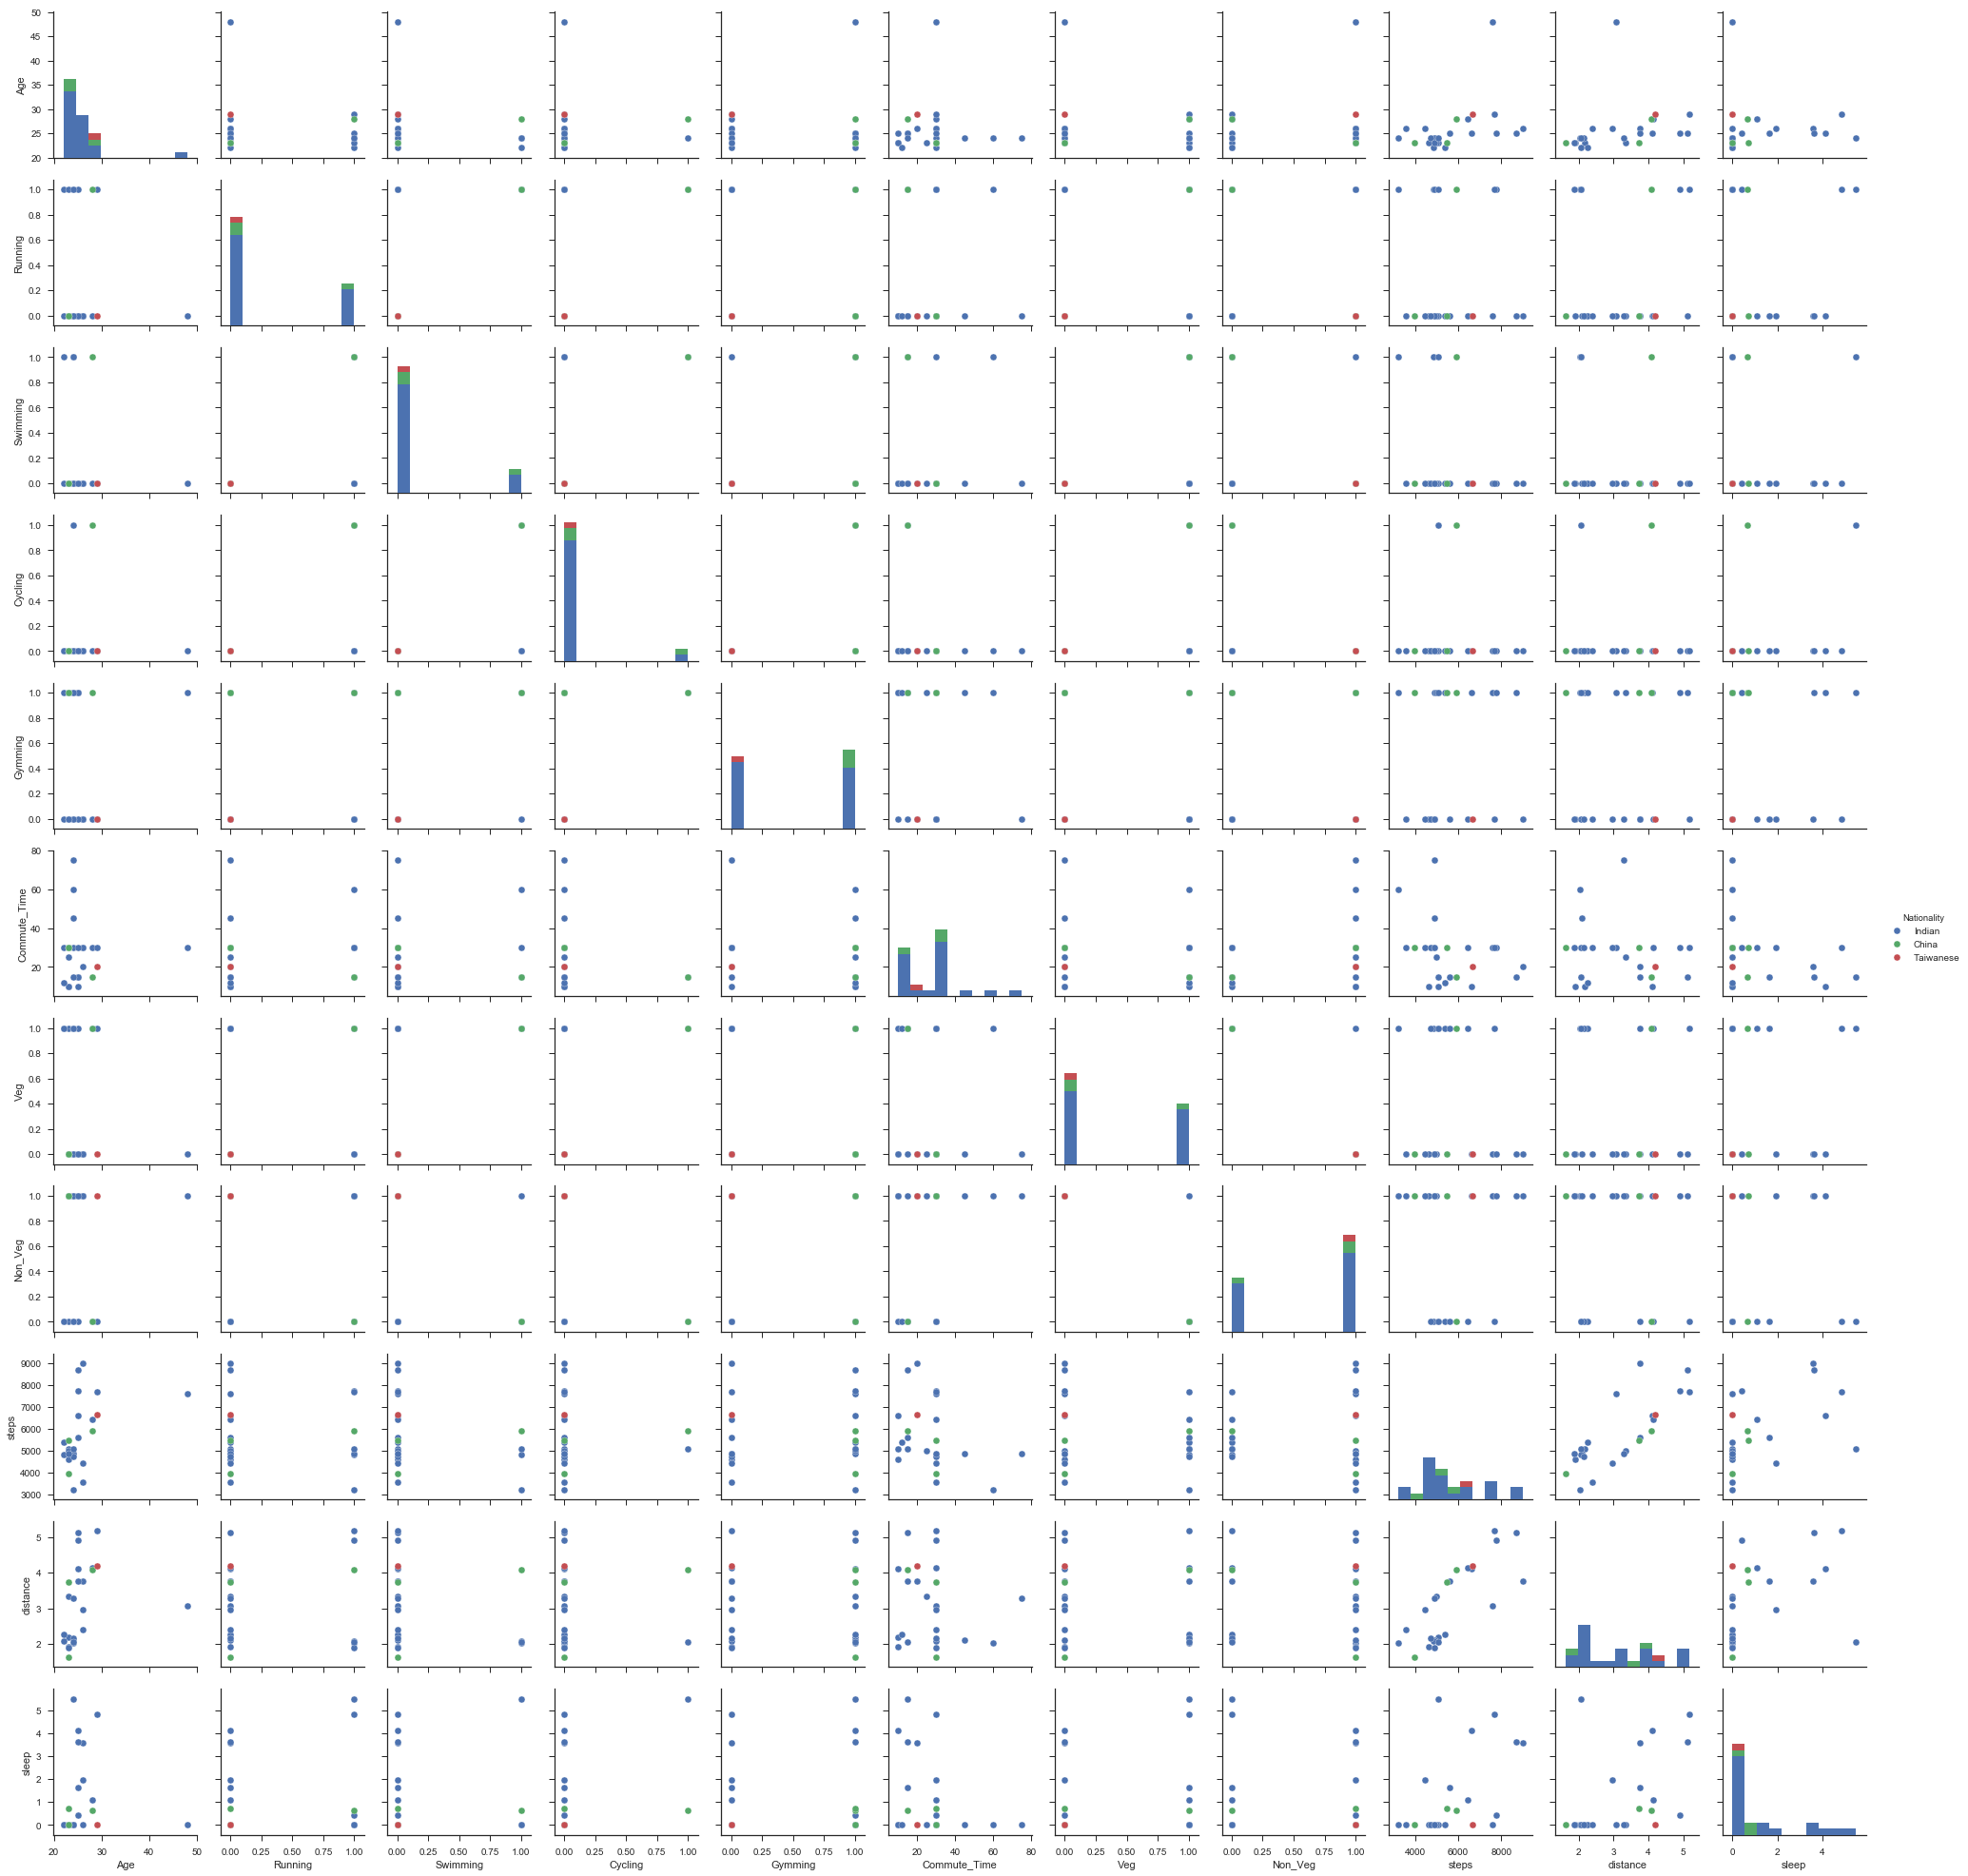

In [21]:
# Lets look at the pairplots first to derive relationships between attributes in our users
pairplot = merged.drop((['id','Name']),axis=1)

g = sns.pairplot(pairplot, hue = 'Nationality')

## Univariate Plots

The univariate plots are helpful to undertand the distrbution of our features

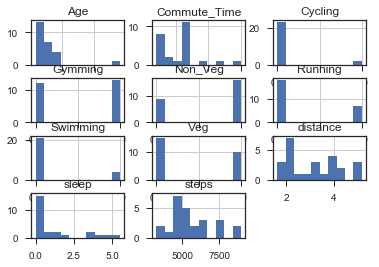

In [22]:
pairplot.hist()
plt.show()

## Density Plots

We also did Density plots to understand the distributions better according to density

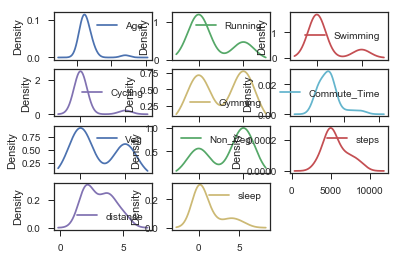

In [23]:
pairplot.plot(kind='density', subplots=True, layout=(4,3), sharex=False)
plt.show()

## Correlation Matrix Plot

From the correlation matrix, we can see that Swimming and Cycling are Highly Correlated (Negatively). Also age and profession are positively correlated. This could help us in grouping users to understand their patterns

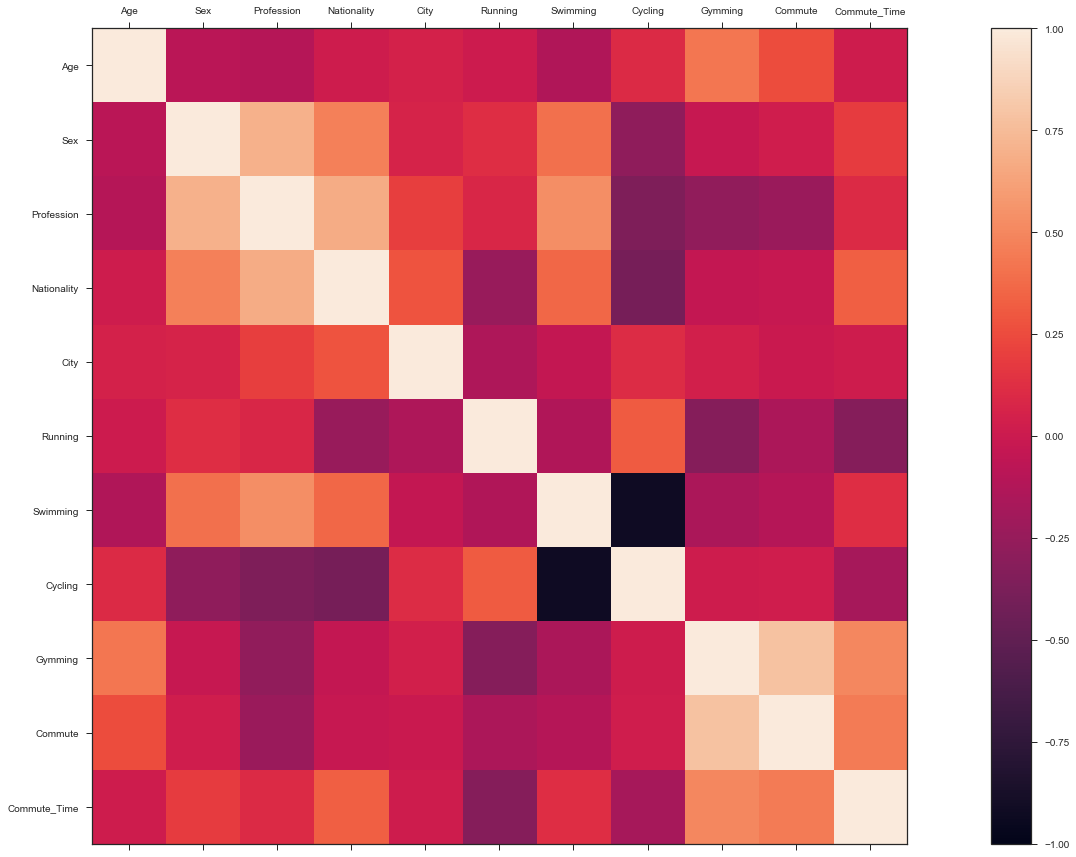

In [25]:
correlations = pairplot.corr()
# plot correlation matrix
fig = plt.figure()
fig.set_size_inches(30, 15)
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,11,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(pairplot.columns.tolist())
ax.set_yticklabels(pairplot.columns.tolist())
plt.show()

## Model : Unsupervised Learning

We decided to use Unsupervised learning because we do not have any Ground Truth data available. The motivation behind using unsupervised learning is to understand **patterns** of User health behaviour and recommend them useful insights to help them **self-reflect** and improve to healthier living patterns

We will be using KMeans clustering to perform our Unsupervised learning

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## One Hot Encoding

In [27]:
merged['Profession']=merged['Profession'].apply(lambda x:x.replace(' ','_'))
merged['City']=merged['City'].apply(lambda x:x.replace(' ','_'))
merged.drop((['id','Name']),axis=1,inplace=True)

In [28]:
def one_hot(df, list_var):
    list_df = pd.get_dummies(df[list_var])
    df = pd.concat([df,list_df],axis=1) 
    return df

In [29]:
def get_object_type(df):
    cat_col = []
    for col in df.columns:
        if df[col].dtype == 'object':
            cat_col.append(col)
    return cat_col

In [30]:
cat_col = get_object_type(pairplot)
clean_cat_col= []
for col in cat_col:
    if col != 'steps' and col != 'steps':
        clean_cat_col.append(col)

merged_clean = one_hot(merged,clean_cat_col)

In [31]:
merged_clean.drop((['Sex','Profession','Nationality','City','Commute']),axis=1,inplace=True)
merged_clean.head()

Age  Running  Swimming  Cycling  Gymming  Commute_Time  Veg  Non_Veg  \
0   23        0         0        0        1            10    1        0   
1   25        0         0        0        1            10    0        1   
2   26        0         0        0        0            20    0        1   
3   24        1         1        0        1            60    1        1   
4   24        0         0        0        1            45    0        1   

         steps  distance      ...       City_Jersey_City  City_Kansas  \
0  5073.455556  2.183262      ...                      0            0   
1  6606.426190  4.100364      ...                      0            0   
2  8978.688889  3.759584      ...                      0            0   
3  3232.273333  2.027935      ...                      0            0   
4  4884.705208  2.102282      ...                      0            1   

   City_Mumbai  City_Perth  City_Pittsburgh  City_SFO  Commute_Bus  \
0            0           0                1         0            0   
1            0           0                1         0            0   
2            0           0                1         0            0   
3            1           0                0         0            1   
4            0           0                0         0            0   

   Commute_Car  Commute_Train  Commute_Walk  
0            0              0             1  
1            0              0             1  
2            0              0             1  
3            0              0             0  
4            1              0             0  

[5 rows x 32 columns]

In [32]:
#change the object data type of categorical data
def change_dtype(df,numeric_names,to_type):
    """
    input:
        df (dataframe): input dataframe
        numeric_names (list): names of numeric data
        to_type (str): target type. 'category', 'str', 'bool'
    
    """
    numeric_col = numeric_names
    categorical_col = list(df.columns.difference(numeric_col))

    for c in categorical_col:
        df[c] = df[c].astype(to_type)
        
    return df

In [33]:
merged_clean.dtypes

Age                               int64
Running                           int64
Swimming                          int64
Cycling                           int64
Gymming                           int64
Commute_Time                      int64
Veg                               int64
Non_Veg                           int64
steps                           float64
distance                        float64
sleep                           float64
Sex_Female                        uint8
Sex_Male                          uint8
Profession_Entrepreneur           uint8
Profession_Freelance_Editor       uint8
Profession_Software_Engineer      uint8
Profession_Student                uint8
Nationality_China                 uint8
Nationality_Indian                uint8
Nationality_Taiwanese             uint8
City_Adelaide                     uint8
City_Delhi                        uint8
City_Jersey_City                  uint8
City_Kansas                       uint8
City_Mumbai                       uint8


In [34]:
merged_clean.head()

Age  Running  Swimming  Cycling  Gymming  Commute_Time  Veg  Non_Veg  \
0   23        0         0        0        1            10    1        0   
1   25        0         0        0        1            10    0        1   
2   26        0         0        0        0            20    0        1   
3   24        1         1        0        1            60    1        1   
4   24        0         0        0        1            45    0        1   

         steps  distance      ...       City_Jersey_City  City_Kansas  \
0  5073.455556  2.183262      ...                      0            0   
1  6606.426190  4.100364      ...                      0            0   
2  8978.688889  3.759584      ...                      0            0   
3  3232.273333  2.027935      ...                      0            0   
4  4884.705208  2.102282      ...                      0            1   

   City_Mumbai  City_Perth  City_Pittsburgh  City_SFO  Commute_Bus  \
0            0           0                1         0            0   
1            0           0                1         0            0   
2            0           0                1         0            0   
3            1           0                0         0            1   
4            0           0                0         0            0   

   Commute_Car  Commute_Train  Commute_Walk  
0            0              0             1  
1            0              0             1  
2            0              0             1  
3            0              0             0  
4            1              0             0  

[5 rows x 32 columns]

In [35]:
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [36]:
print(merged_clean["steps"].head())
print(merged_clean["sleep"].head())
print(merged_clean["distance"].head())

0    5073.455556
1    6606.426190
2    8978.688889
3    3232.273333
4    4884.705208
Name: steps, dtype: float64
0    0.000000
1    4.130765
2    3.579188
3    0.000000
4    0.000000
Name: sleep, dtype: float64
0    2.183262
1    4.100364
2    3.759584
3    2.027935
4    2.102282
Name: distance, dtype: float64


In [37]:
cols = merged_clean.columns
print(cols)

Index(['Age', 'Running', 'Swimming', 'Cycling', 'Gymming', 'Commute_Time',
       'Veg', 'Non_Veg', 'steps', 'distance', 'sleep', 'Sex_Female',
       'Sex_Male', 'Profession_Entrepreneur', 'Profession_Freelance_Editor',
       'Profession_Software_Engineer', 'Profession_Student',
       'Nationality_China', 'Nationality_Indian', 'Nationality_Taiwanese',
       'City_Adelaide', 'City_Delhi', 'City_Jersey_City', 'City_Kansas',
       'City_Mumbai', 'City_Perth', 'City_Pittsburgh', 'City_SFO',
       'Commute_Bus', 'Commute_Car', 'Commute_Train', 'Commute_Walk'],
      dtype='object')


In [38]:
cluster = KMeans(n_clusters = 6)

In [70]:
merged_clean["cluster"] = cluster.fit_predict(merged_clean)

In [40]:
from scipy.spatial.distance import cdist
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(merged_clean)
    kmeanModel.fit(merged_clean)
    distortions.append(sum(np.min(cdist(merged_clean, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / merged_clean.shape[0])



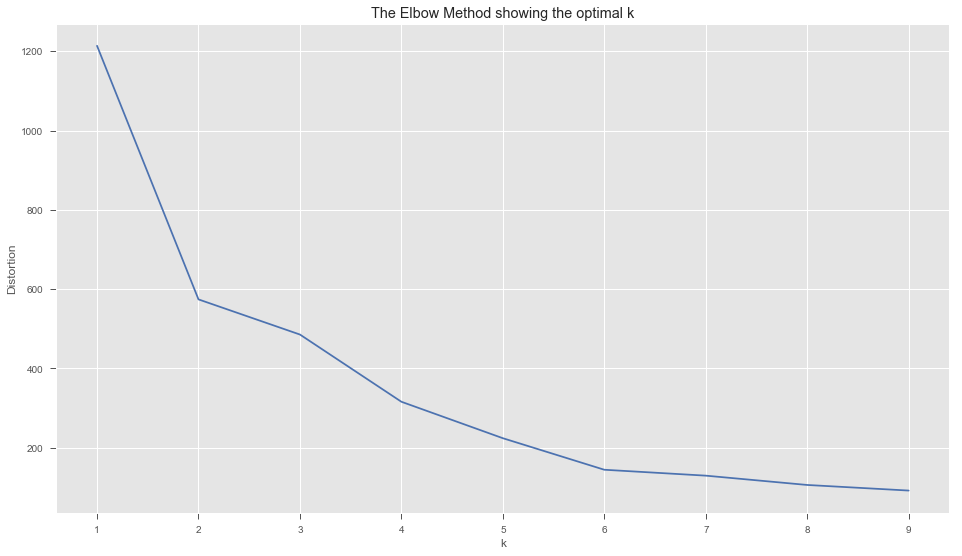

In [41]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# PCA Component Creation to Visualize Clusters better

In the below approach, we are creating 2 PCA components, x and y reduce our dimensionality and visualize our clusters better.

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

merged_clean["x"] = pca.fit_transform(merged_clean[cols])[:,0]
merged_clean["y"] = pca.fit_transform(merged_clean[cols])[:,1]
merged_clean = merged_clean.reset_index()

In [43]:
merged_clean.tail()

index  Age  Running  Swimming  Cycling  Gymming  Commute_Time  Veg  \
20     20   29        1         0        0        0            30    1   
21     21   23        0         0        0        1            30    0   
22     22   23        0         0        0        1            30    0   
23     23   24        1         1        1        1            15    1   
24     24   29        0         0        0        0            20    0   

    Non_Veg        steps    ...      City_Perth  City_Pittsburgh  City_SFO  \
20        0  7682.252941    ...               0                1         0   
21        1  3951.920833    ...               0                1         0   
22        1  5483.919608    ...               0                1         0   
23        0  5092.648485    ...               0                1         0   
24        1  6647.680000    ...               0                1         0   

    Commute_Bus  Commute_Car  Commute_Train  Commute_Walk  cluster  \
20            0            0              0             1        2   
21            0            0              0             1        3   
22            0            0              0             1        5   
23            0            0              0             1        1   
24            0            0              0             1        0   

              x          y  
20  2005.328686   9.375952  
21 -1724.992209  -2.710310  
22  -193.001967   2.131796  
23  -584.218441 -14.121743  
24   970.791726  -3.761315  

[5 rows x 36 columns]

In [44]:
final_clusters = merged_clean[['Age','steps','x','y']]

In [45]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode()

We will now create a scatter plot for all of the 6 Clusters that we have chosen using the Elbow approach with lowest decrease in losses.

In [46]:
trace0 = go.Scatter(x =final_clusters[merged_clean.cluster == 0]["x"],
                    y = final_clusters[merged_clean.cluster == 0]["y"],
                    name = "Cluster 1",
                    mode = "markers",
                    marker = dict(size = 10,
                                 color = "rgba(15,152,152,0.5)",
                                 line = dict(width = 1, color = "rgb(0,0,0)")))
trace1 = go.Scatter(x =final_clusters[merged_clean.cluster == 1]["x"],
                    y = final_clusters[merged_clean.cluster == 1]["y"],
                    name = "Cluster 2",
                    mode = "markers",
                    marker = dict(size = 10,
                                 color = "rgba(180,18,180,0.5)",
                                 line = dict(width = 1, color = "rgb(0,0,0)")))
trace2 = go.Scatter(x =final_clusters[merged_clean.cluster == 2]["x"],
                    y = final_clusters[merged_clean.cluster == 2]["y"],
                    name = "Cluster 3",
                    mode = "markers",
                    marker = dict(size = 10,
                                 color = "rgba(132,132,132,0.8)",
                                 line = dict(width = 1, color = "rgb(0,0,0)")))
trace3 = go.Scatter(x =final_clusters[merged_clean.cluster == 3]["x"],
                    y = final_clusters[merged_clean.cluster == 3]["y"],
                    name = "Cluster 4",
                    mode = "markers",
                    marker = dict(size = 10,
                                 color = "rgba(122,122,12,0.8)",
                                 line = dict(width = 1, color = "rgb(0,0,0)")))
trace4 = go.Scatter(x =final_clusters[merged_clean.cluster == 4]["x"],
                    y = final_clusters[merged_clean.cluster == 4]["y"],
                    name = "Cluster 5",
                    mode = "markers",
                    marker = dict(size = 10,
                                 color = "rgba(210,20,30,0.5)",
                                 line = dict(width = 1, color = "rgb(0,0,0)")))
trace5 = go.Scatter(x =final_clusters[merged_clean.cluster == 4]["x"],
                    y = final_clusters[merged_clean.cluster == 4]["y"],
                    name = "Cluster 5",
                    mode = "markers",
                    marker = dict(size = 10,
                                 color = "rgba(240,60,70,0.5)",
                                 line = dict(width = 1, color = "rgb(0,0,0)")))



data = [trace0,trace1,trace2,trace3,trace4,trace5]
iplot(data)

### Creating New Features to identify specific clusters

These features will be helpful to understand the business value and make inferences from our clusters by comparing all features against the ones which are interpretable in different clusters

In [47]:
merged_clean["0"] = merged_clean.cluster == 0
merged_clean["1"] = merged_clean.cluster == 1
merged_clean["2"] = merged_clean.cluster == 2
merged_clean["3"] = merged_clean.cluster == 3
merged_clean["4"] = merged_clean.cluster == 4
merged_clean["5"] = merged_clean.cluster == 5

In [48]:
merged_clean.groupby(['0']).Age.value_counts()

0      Age
False  23     6
       24     5
       25     3
       26     3
       22     2
       28     1
       29     1
       48     1
True   25     1
       28     1
       29     1
Name: Age, dtype: int64

In [49]:
merged_clean.groupby(['1']).Running.value_counts()

1      Running
False  0          11
       1           4
True   0           7
       1           3
Name: Running, dtype: int64

In [50]:
merged_clean.groupby(['2']).Running.value_counts()

2      Running
False  0          17
       1           5
True   1           2
       0           1
Name: Running, dtype: int64

In [51]:
merged_clean.groupby(['3']).Running.value_counts()

3      Running
False  0          16
       1           6
True   0           2
       1           1
Name: Running, dtype: int64

In [52]:
merged_clean.groupby(['4']).Running.value_counts()

4      Running
False  0          16
       1           7
True   0           2
Name: Running, dtype: int64

## Cluster Analysis and Recommendations

In this phase we interpret each of the clusters separately to understand the useful and **meaningful patterns** in our data. 

We were able to find out insights by highest **average steps, sleep and distance patterns.**

In the below section, we give an example of a sample analysis of clusters by **highest average steps**

In [53]:
merged_new = user_information[['Sex', 'Profession', 'Nationality','City','Commute','Name']].copy()

merged_clean_new = merged_clean

analysis_df = pd.concat((merged_clean_new,merged_new),axis=1)

analysis_df.columns

Index(['index', 'Age', 'Running', 'Swimming', 'Cycling', 'Gymming',
       'Commute_Time', 'Veg', 'Non_Veg', 'steps', 'distance', 'sleep',
       'Sex_Female', 'Sex_Male', 'Profession_Entrepreneur',
       'Profession_Freelance_Editor', 'Profession_Software_Engineer',
       'Profession_Student', 'Nationality_China', 'Nationality_Indian',
       'Nationality_Taiwanese', 'City_Adelaide', 'City_Delhi',
       'City_Jersey_City', 'City_Kansas', 'City_Mumbai', 'City_Perth',
       'City_Pittsburgh', 'City_SFO', 'Commute_Bus', 'Commute_Car',
       'Commute_Train', 'Commute_Walk', 'cluster', 'x', 'y', '0', '1', '2',
       '3', '4', '5', 'Sex', 'Profession', 'Nationality', 'City', 'Commute',
       'Name'],
      dtype='object')

In [54]:
analysis_df.groupby(['0']).Sex.value_counts()

0      Sex   
False  Male      13
       Female     9
True   Male       2
       Female     1
Name: Sex, dtype: int64

In [55]:
analysis_df.groupby(['1']).Sex.value_counts()

1      Sex   
False  Male      10
       Female     5
True   Female     5
       Male       5
Name: Sex, dtype: int64

In [56]:
analysis_df.head()

index  Age  Running  Swimming  Cycling  Gymming  Commute_Time  Veg  \
0      0   23        0         0        0        1            10    1   
1      1   25        0         0        0        1            10    0   
2      2   26        0         0        0        0            20    0   
3      3   24        1         1        0        1            60    1   
4      4   24        0         0        0        1            45    0   

   Non_Veg        steps       ...             2      3      4      5     Sex  \
0        0  5073.455556       ...         False  False  False  False    Male   
1        1  6606.426190       ...         False  False  False  False    Male   
2        1  8978.688889       ...         False  False   True  False    Male   
3        1  3232.273333       ...         False   True  False  False    Male   
4        1  4884.705208       ...         False  False  False  False  Female   

          Profession  Nationality        City  Commute             Name  
0            Student       Indian  Pittsburgh     Walk    Bhavya Sharma  
1            Student       Indian  Pittsburgh     Walk       Ayush Jain  
2            Student       Indian  Pittsburgh     Walk   Rohan Panikkar  
3   Freelance Editor       Indian      Mumbai      Bus         Om Khard  
4  Software Engineer       Indian      Kansas      Car  Vidushi Dikshit  

[5 rows x 48 columns]

In [57]:
analysis_df[analysis_df.cluster==0]["Commute"].count()

3

From our analysis we can infer that Commute has maximum counts in **Cluster 2** (Cluster Index 1), but it is mixed form, **Walk, Bus, Train and Car**. This does not point us to any valuable insight but only helps us understand the nature of the cluster

In [58]:
analysis_df.groupby(['1']).Commute.value_counts()

1      Commute
False  Walk       9
       Bus        4
       Car        2
True   Walk       4
       Bus        3
       Train      2
       Car        1
Name: Commute, dtype: int64

In [59]:
analysis_df.groupby(['0']).steps.mean()

0
False    5555.514915
True     6567.138175
Name: steps, dtype: float64

In [60]:
analysis_df.groupby(['1']).steps.mean()

1
False    6233.210009
True     4842.459252
Name: steps, dtype: float64

In [61]:
analysis_df.groupby(['2']).steps.mean()

2
False    5404.844824
True     7672.052171
Name: steps, dtype: float64

In [62]:
analysis_df.groupby(['3']).steps.mean()

3
False    5961.760429
True     3588.004405
Name: steps, dtype: float64

From the below two analysis steps, we can identify **Cluster 5 (Cluster Index 4)** has **highest mean** of average **steps**. Also, the only means to commute in this cluster is by **Walk**

In [63]:
analysis_df.groupby(['4']).steps.mean()

4
False    5402.935067
True     8827.618056
Name: steps, dtype: float64

In [64]:
analysis_df.groupby(['5']).steps.mean()

5
False    5693.400613
True     5590.332442
Name: steps, dtype: float64

In [65]:
analysis_df.groupby(['1']).Commute.value_counts()

1      Commute
False  Walk       9
       Bus        4
       Car        2
True   Walk       4
       Bus        3
       Train      2
       Car        1
Name: Commute, dtype: int64

## The Winners

From our example of using one of the metrics **Step Count**, Cluster 5 (Cluster Index = 4) gives two users, Rohan Panikkar and Devang Varia who have the best Step averages. We can infer that these users tend to be healthier on average by looking at their datapoints

In [71]:
analysis_df[analysis_df.cluster==4]["Name"]

2    Rohan Panikkar
8      Devang Varia
Name: Name, dtype: object

### Analysis of Winners

In [67]:
analysis_df.loc[analysis_df['index'] == 2]

index  Age  Running  Swimming  Cycling  Gymming  Commute_Time  Veg  \
2      2   26        0         0        0        0            20    0   

   Non_Veg        steps       ...            2      3     4      5   Sex  \
2        1  8978.688889       ...        False  False  True  False  Male   

   Profession  Nationality        City  Commute            Name  
2     Student       Indian  Pittsburgh     Walk  Rohan Panikkar  

[1 rows x 48 columns]

In [68]:
analysis_df.loc[analysis_df['index'] == 8]

index  Age  Running  Swimming  Cycling  Gymming  Commute_Time  Veg  \
8      8   25        0         0        0        1            15    0   

   Non_Veg        steps      ...           2      3     4      5   Sex  \
8        1  8676.547222      ...       False  False  True  False  Male   

   Profession  Nationality        City  Commute          Name  
8     Student       Indian  Pittsburgh     Walk  Devang Varia  

[1 rows x 48 columns]

## No. of Steps for User 8 (Devang Varia)

When we check for both users, we inferred that User 8 has a better Steps Pattern and is clearly our winner

/anaconda3/lib/python3.6/site-packages/calmap/__init__.py:294: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...).sum()

/anaconda3/lib/python3.6/site-packages/calmap/__init__.py:146: MatplotlibDeprecationWarning:

The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.



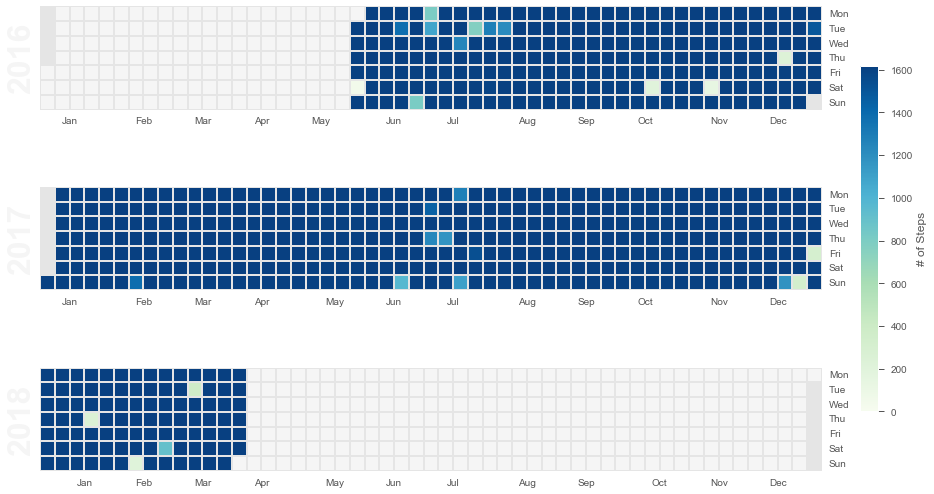

In [69]:
import matplotlib
steps_analysis_features[8] = steps_analysis_features[8][steps_analysis_features[8].value != 0]
steps_analysis_features[8].index=pd.to_datetime(steps_analysis_features[8].END_DATE)
events = pd.Series(steps_analysis_features[8]['value'])
fig,ax=calmap.calendarplot(events, monthticks=True, cmap='GnBu', vmin=0, 
                           vmax=max(steps_analysis_features[8]['value']),fig_kws=dict(figsize=(12, 8)));
c = fig.add_axes([1.0, 0.2, 0.02, 0.6])
normalize = matplotlib.colors.Normalize(0,max(steps_analysis_features[8]['value']))
cb = matplotlib.colorbar.ColorbarBase(c, cmap='GnBu', norm=normalize)
cb.set_label('# of Steps')

# Future Enhancements

In the future, we could create a HealthScore which can be calculated based on insights from our Clusters and then label our **Ground Truth label**. This will be very useful to use for a **Classification** algorithims which can then be used for **Real-Time** analysis of Health Index for users on a Daily Basis.

Through this project, we hope to use the insights to help users in self-reflection of their data and then improve their overall health.

# References

1. https://developer.apple.com/documentation/healthkit

2. http://www.ryanpraski.com/apple-health-data-how-to-export-analyze-visualize-guide/

3. http://ericwolter.com/projects/health-export.html

4. https://github.com/amandasolis/Fitbit/blob/master/FitbitSummaryPlots.ipynb

